In [1]:
import cv2
import numpy as np
import onnxruntime as ort
from collections import deque
from modelArc import CRNN
from itertools import groupby
from matplotlib import pyplot as plt

In [2]:
model_path = r"D:\Projects\reciept-scanner\RCNN\models\202407310100\model.onnx"

class inferencemode:
    def __init__(self, model_path: str = ""):
        self.model_path = model_path.replace("\\", "/")
        providers = ["CUDAExecutionProvider", "CPUExecutionProvider"] if ort.get_device() == "GPU" else ["CPUExecutionProvider"]

        self.model = ort.InferenceSession(model_path, providers = providers)

        self.metadata = {}
        for key, value in self.model.get_modelmeta().custom_metadata_map.items():
            new_value = value
            self.metadata[key] = new_value

        self.input_shapes = [meta.shape for meta in self.model.get_inputs()]
        self.input_names = [meta.name for meta in self.model._inputs_meta]
        self.output_names = [meta.name for meta in self.model._outputs_meta]

    def predict(self, image: np.ndarray):
        image = cv2.resize(image, (128, 32))

        image_pred = np.expand_dims(image, axis=0).astype(np.float32)

        preds = self.model.run(self.output_names, {self.input_names[0]: image_pred})[0]

        #highest prob
        argmax_preds = np.argmax(preds, axis=-1)
        grouped_preds = [[k for k,_ in groupby(preds)] for preds in argmax_preds]
        texts = ["".join([self.metadata["vocab"][k] for k in group if k < len(self.metadata["vocab"])]) for group in grouped_preds]
        text = texts[0]

        return text
    
    def run(self, image: np.ndarray, bbox_coords: list): #list of format [[xmin, xmax, ymin, ymax], [xmin, xmax, ymin, ymax], [xmin, xmax, ymin, ymax],....]
        bboxes = []
        for i, (x_min, x_max, y_min, y_max) in enumerate(bbox_coords):
            box = image[y_min:y_max, x_min:x_max,]
            bboxes.append(box)
        
        results = []
        for b in bboxes:

            # plt.figure(figsize=(10, 2))
            # plt.imshow(b, cmap='gray')

            grey_image = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
            _, binary_image = cv2.threshold(grey_image, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
            kernel = np.ones((10, 36), np.uint8)
            dilated_image = cv2.dilate(binary_image, kernel, iterations=1)
            contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            min_contour_area = 1000
            filtered_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]
            bounding_boxes = [cv2.boundingRect(c) for c in filtered_contours]
            bounding_boxes = sorted(bounding_boxes, key=lambda x: x[1])

            elements = []
            for i, (x, y, w, h) in enumerate(bounding_boxes):
                if w > 20 and h> 25:
                    line_image = b[y:y+h, x:x+w]
                    elements.append(line_image)

            text = []
            for capture in elements:
                prediction_text = self.predict(capture)
                text.append(prediction_text)
            results.append(text)

            # for (x, y, w, h) in bounding_boxes:
            #     if w > 20 and h> 25:
            #        cv2.rectangle(b, (x, y), (x+w, y+h), (0, 255, 0), 2)
            # Plot the image with bounding boxes
            # plt.figure(figsize=(10, 2))
            # plt.imshow(b, cmap='gray')
            # plt.title('Detected Lines')
            # plt.axis('off')
            # plt.show()
            # print(text)
        return results #results is a [[item: str], [item: str], [item: str], [item: str]....]

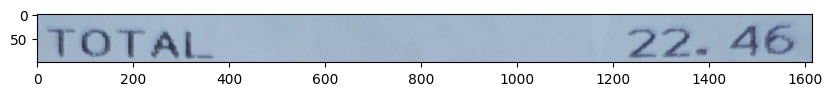

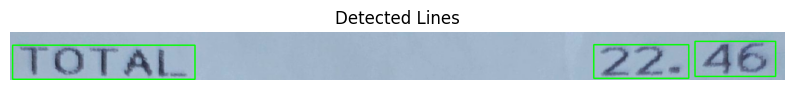

['46', '224', 'TOTAL']


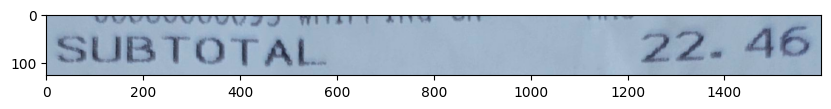

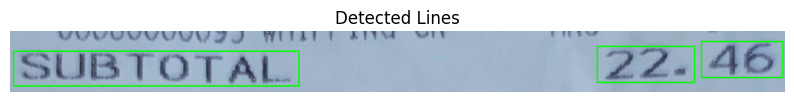

['46', '224', 'SUBTOTAL']


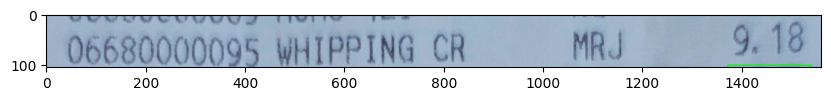

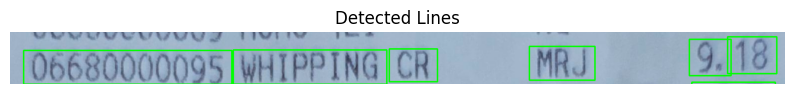

['18', '%', 'MM', 'CR', 'NIPFRINO', '06660000055']


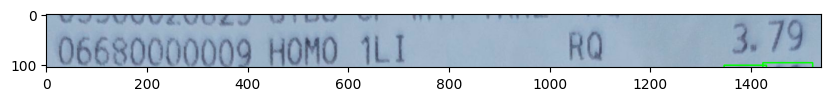

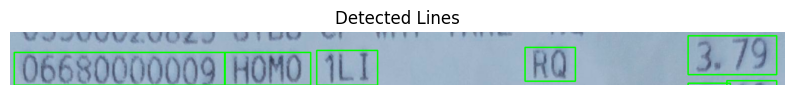

['3.79', '@', '11T', 'ROND', '06660000009']


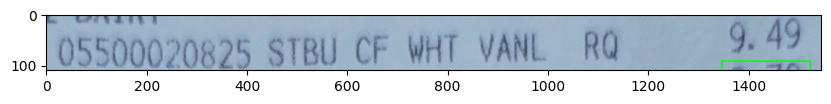

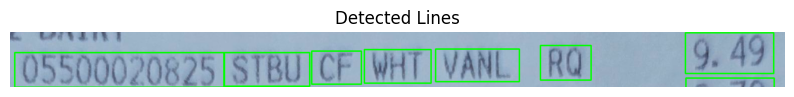

['9.49', '@', 'AM', 'NMT', 'CR', 'STED', 'C55000200235']
['46', '224', 'TOTAL']
['46', '224', 'SUBTOTAL']
['18', '%', 'MM', 'CR', 'NIPFRINO', '06660000055']
['3.79', '@', '11T', 'ROND', '06660000009']
['9.49', '@', 'AM', 'NMT', 'CR', 'STED', 'C55000200235']


In [26]:
#overall function
# testing
bboxCoord = [[105, 1720, 1415, 1515], [105, 1705, 1235, 1360], [160, 1720, 1155, 1260], [180, 1720, 1070, 1175], [180, 1725, 985, 1095]]

img_path = r"D:\photos\RCNN4\train\20240706_015503_jpg.rf.480d069b4a243d281112d1daf06b8862.jpg"
image = cv2.imread(img_path.replace("\\", "/"))

tester = inferencemode(model_path)

results = tester.run(image, bboxCoord)
for i in results:
    print(i)


In [16]:
img_path = r"D:\photos\RCNN4\BBOXES\75.jpg"
#"D:\photos\SORIE\test\0afc0804-7e6e-4e77-ab68-8d9384918be7.jpg"

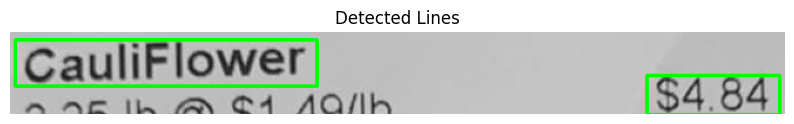

Prediction is: CASHIETIED
Prediction is: $4.84


In [4]:
# img_path = r"C:\Users\Gary Guo\Downloads\testimage.png"
img_path = r"D:\photos\RCNN4\BBOXES\13.jpg"
image = cv2.imread(img_path.replace("\\", "/"), cv2.IMREAD_GRAYSCALE)#np array

_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

kernel = np.ones((5, 20), np.uint8)

dilated_image = cv2.dilate(binary_image, kernel, iterations=1)

contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

min_contour_area = 1000
filtered_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

bounding_boxes = [cv2.boundingRect(c) for c in filtered_contours]
bounding_boxes = sorted(bounding_boxes, key=lambda x: x[1])

elements = []
color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for i, (x, y, w, h) in enumerate(bounding_boxes):
    if w > 20 and h>25:
        line_image = color_image[y:y+h, x:x+w]
        elements.append(line_image)

model = inferencemode(model_path)
for (x, y, w, h) in bounding_boxes:
    if w > 20 and h>25:
        cv2.rectangle(color_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
# Plot the image with bounding boxes
plt.figure(figsize=(10, 2))
plt.imshow(color_image, cmap='gray')
plt.title('Detected Lines')
plt.axis('off')
plt.show()

for capture in elements:
    prediction_text = model.predict(capture)
    print(f"Prediction is: {prediction_text}")